# **WORKFLOW FOR PROTEOMICS RELATIVE QUANTIFICATION**

## *IGBMC - Proteomics and mass-spectroscopy platform*

#### Paul BLANC


***

### 1. Introduction
This notebook outlines a bioanalytical workflow for relative quantification for proteomics.

***

### 2. Import of the required libraries
To execute this workflow we'll use a combination of python libraries and data analysis tools:
- `pandas` for dataframe importation and manipulation.
- `matplotlib` for data visualization.
- `numpy` for calculations.
- `scikit learn` to perform principal component analysis and normalization.
- `scipy` to perform statitic student's t-test.
- `statsmodels.stats.multitest` to perfrom benjamini-hochberg p-value correction.

Please execute the cell below to import the desired framework.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

***

### 2. Loading of the files
We'll need to download two files to run this workflow. Both files are proteome dicover results in txt format, with tabs as column separators.
- `df_data` contains the quantification results as such, with the quantification per sample for each protein. After uploading of the file in proteome discover, the file will be named as  *specific_name+Proteins.txt*
- `df_info` contains information about samples. We're going to use this file because it will enable us to rename the samples easily, so that they can be sorted and grouped. After uploading of the file in proteome discover, the file will be named as  *specific_name+StudyInformation.txt*

Firstly you can load the txt file from proteome discover holding the quantitative data and the txt file containing samples names.


Please replace 'file_path' by the path of your txt file named as  *specific_name+Proteins.txt* , and then execute the cell.

In [11]:
file_path=r"C:\Users\blancp\Desktop\241129_DEV doc\dataFragPipe220\FragPipe_combined_protein.txt"
df_data = pd.read_csv(file_path, sep='\t')
df_data.head()

,Protein,Protein ID,Entry Name,Gene,Protein Length,Organism,Protein Existence,Description,Protein Probability,Top Peptide Probability,...,dose2_9 MaxLFQ Intensity,dose3_13 MaxLFQ Intensity,dose3_14 MaxLFQ Intensity,dose3_15 MaxLFQ Intensity,dose3_16 MaxLFQ Intensity,dose4_17 MaxLFQ Intensity,dose4_18 MaxLFQ Intensity,dose4_19 MaxLFQ Intensity,dose4_20 MaxLFQ Intensity,Indistinguishable Proteins
0,sp|A0A2R8Y4L2|RA1L3_HUMAN,A0A2R8Y4L2,RA1L3_HUMAN,HNRNPA1L3,320,Homo sapiens,4:Protein predicted,Heterogeneous nuclear ribonucleoprotein A1-like 3,1.0,0.999,...,69910016.0,70263384.0,64271476.0,67015404.0,73621704.0,82722464.0,77956312.0,77042888.0,75274112.0,NaN
1,sp|A0AV96|RBM47_HUMAN,A0AV96,RBM47_HUMAN,RBM47,593,Homo sapiens,1:Experimental evidence at protein level,RNA-binding protein 47,1.0,0.999,...,2959166.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sp|A0AVT1|UBA6_HUMAN,A0AVT1,UBA6_HUMAN,UBA6,1052,Homo sapiens,1:Experimental evidence at protein level,Ubiquitin-like modifier-activating enzyme 6,1.0,0.999,...,5539439.5,6007295.5,5842070.0,6804404.5,5823037.5,6169762.5,6475805.0,6130870.5,6227343.0,NaN
3,sp|A0FGR8|ESYT2_HUMAN,A0FGR8,ESYT2_HUMAN,ESYT2,921,Homo sapiens,1:Experimental evidence at protein level,Extended synaptotagmin-2,1.0,0.999,...,3874512.8,5021623.0,4461075.0,4669667.5,4436277.5,3668694.5,4851536.5,3746609.5,3747597.0,NaN
4,sp|A0MZ66|SHOT1_HUMAN,A0MZ66,SHOT1_HUMAN,SHTN1,631,Homo sapiens,1:Experimental evidence at protein level,Shootin-1,1.0,0.999,...,7852435.5,7382556.5,6586127.0,7860661.5,7342229.5,7432794.5,7203025.0,7317379.5,7979564.5,NaN


Please replace 'file_path' by the path of your txt file named as  *specific_name+StudyInformation.txt* , and then execute the cell.

In [13]:
file_path = r"C:\Users\blancp\Desktop\241129_DEV doc\241118_DEV_dda_StudyInformation.txt"
df_info = pd.read_csv(file_path, sep='\t')
df_info.head()

,Study Information Id,Checked,Sample,File ID,Sample Identifier,File Name,Sample Type
0,1,False,S1,F1,241118_DEV_dda_dose0_rep1,D:\data\2024\241129_DEV_HelaColi\241118_DEV_dd...,Sample
1,2,False,S2,F2,241118_DEV_dda_dose0_01,D:\data\2024\241129_DEV_HelaColi\241118_DEV_dd...,Sample
2,3,False,S3,F3,241118_DEV_dda_dose0_02,D:\data\2024\241129_DEV_HelaColi\241118_DEV_dd...,Sample
3,4,False,S4,F4,241118_DEV_dda_dose0_03,D:\data\2024\241129_DEV_HelaColi\241118_DEV_dd...,Sample
4,5,False,S5,F5,241118_DEV_dda_dose0_04,D:\data\2024\241129_DEV_HelaColi\241118_DEV_dd...,Sample


***

### 2. Functions
We can see below the cell containing the focntions that will be used later to execute the program. The role of each function is as follows:
- `categories_add_DIA` allows you to add a column containing the species associated with each protein by extracting the species in the protein column. In this way, we can compare species. We use this function only for data acquired in DIA, as this column already exists for data acquired in DDA.
- `gene_name_add_DDA` allows you to add a column containing the gene name associated with each protein by extracting the gene name in the protein column. In this way, we can compare protein by their gene, which is more easier. We use this function only for data acquired in DDA, as this column already exists for data acquired in DIA.
- `classifier_variables`allows you to classify the variables associated with each dataframe column into different types: *CATEGORICAL*, *MAIN* (which corresponds to quantification measures), *STR* for text variables and *NUMERICAL* for numerical variables.
- `classifier_categories` create a list containing the string values associated with the *CATEGORICAL* variable.
- `fill_empty_cat` fills in proteins with an empty *CATEGORICAL* column with a zero text value.
- `categories_removal` removes unwanted categories.
- `rename_samples` rename samples with dataframe *df_info*
- `contaminant_removal` removes contaminants
- `column_deletion_2v`deletes unwanted columns in the *df_data* dataframe and in the variables dictionary
- `column_deletion_3v`removes unwanted columns from the *df_data* dataframe, the variables dictionary and the sample_groups list
- `empty_row_removal`removes rows that do not contain quantification measurements
- `descriptive_stat`creates two graphs showing the mean and median quantification for each sample
- `grouping`groups samples by taking the first digit in their names
- `log2_transform`allows quantification data to be converted into log2(x)
- `data_imputation` allows you to fill empty cells in *MAIN* columns using the normal distribution.
- `PCA_data`allows you to create a graph presenting a principal component analysis of our data using two principal components
- `row_z_score_normalization`normalizes the dataset using the z-score on each columns
- `median_substraction_column`normalizes the dataset by subtracting the median from each column.
- `paired_t_test`perform a student's statistical test, comparing the measurements of a group of n replicate samples with another group of samples for each protein.
- `volcano_plot`to create a volcanoplot and sort the results.
- `parameters`to calculate sensitivity and specificity

Please execute the cell below.

In [16]:
def categories_add_DIA(df_data):
    categories_DIA = []
    for row in df_data['Protein.Names']:
        if "_" in row:
            categories_DIA.append(row.split('_')[-1])
        else:
            categories_DIA.append(row)
    df_data['categories_DIA'] = categories_DIA
    return df_data

def gene_name_add_DDA(df_data):
    df_data['gene_name_DDA'] = ""
    for row in range(len(df_data)):
        start = df_data.loc[row, 'Description'].find("GN=")
        if start != -1:
            df_data.loc[row, 'gene_name_DDA'] = df_data.loc[row, 'Description'][start + 3:start + 7]
    return df_data

def classifier_variables(df):
    try:
        if not isinstance(df, pd.DataFrame):
            raise ValueError("The input must be a valid dataframe.")
        variables = {"NUMERICAL": [], "CATEGORICAL": [], "STR": [],"MAIN":[]}
        candidate_categoricals = []
        for col in df.columns:
            unique_values = df[col].nunique()
            contains_digits = df[col].astype(str).str.contains(r'\d').any()
            if pd.api.types.is_numeric_dtype(df[col]):
                if (df[col] > 10000).any():
                    if (df[col] < -1).any():
                        variables["NUMERICAL"].append(col)
                    else:
                        if (df[col].max() > 900000):
                            variables["MAIN"].append(col)
                        else:
                            variables["NUMERICAL"].append(col)
                else:
                        variables["NUMERICAL"].append(col)
            elif 2 <= unique_values <= 6 and not contains_digits:
                candidate_categoricals.append(col)
            else:
                variables["STR"].append(col)
        if len(candidate_categoricals) == 1:
            variables["CATEGORICAL"].append(candidate_categoricals[0])
        elif len(candidate_categoricals) > 1:
            print("Several categorical variables were found:")
            for i, col in enumerate(candidate_categoricals, start=1):
                print(f"{i}. {col}")
            while True:
                try:
                    choice = int(input("Select the number of the categorical variable (e.g. 1, 2, etc.): "))
                    if 1 <= choice <= len(candidate_categoricals):
                        selected_categorical = candidate_categoricals[choice - 1]
                        variables["CATEGORICAL"].append(selected_categorical)
                        break
                    else:
                        print(f"Please select a valid number between 1 and {len(candidate_categoricals)}.")
                except ValueError:
                    print("Invalid input. Please enter a number.")
            for col in candidate_categoricals:
                if col != variables["CATEGORICAL"]:
                    variables["STR"].append(col)
        elif len(candidate_categoricals) ==0:
            print("No categorical variables were found")
            for i, col in enumerate(df.columns, start=1):
                print(f"{i}. {col}")
            while True:
                choice_categorical_column = input("Please enter the number associated with the categorical colum (1, 2, etc.): ")
                if choice_categorical_column.isdigit():
                    choice_categorical_column=int(choice_categorical_column)
                    if choice_categorical_column <= 0:
                        print("Invalid input.")
                    elif choice_categorical_column > len(df.columns)+1:
                        print("Invalid input.")
                    else:
                        categorical_colum = df.columns[choice_categorical_column - 1]
                        break
                else:
                    print("Invalid input.")
            variables['CATEGORICAL'].append(categorical_colum)    
        print("\nClassified variables:")
        for category, cols in variables.items():
            print(f"- {category}: {cols}")
        print("\nLength of each category:")
        for category, cols in variables.items():
            print(f"- {category}: {len(cols)}")
        unconfirmation_flag=False
        while True:
            confirmation=input("Can you confirm the classification results? (YES: 1 | NO: 0) ?")
            if confirmation.isdigit():
                confirmation=int(confirmation)
                if confirmation ==1:
                    break
                elif confirmation ==0:
                    unconfirmation_flag=True
                    break
                else:
                    print("Invalid input.")
            else:
                print("Invalid input.")
        main_column_deletion_flag=False
        categorical_column_deletion_flag=False
        change_categorie_flag=False
        if unconfirmation_flag==True:
            while True:
                choice_categorical_column_deletion=input("Do you want to delete column(s) wrongly associated as categorical ? (YES: 1 | NO: 0)")
                if choice_categorical_column_deletion.isdigit():
                    choice_categorical_column_deletion=int(choice_categorical_column_deletion)
                    if choice_categorical_column_deletion ==0:
                        break
                    elif choice_categorical_column_deletion ==1:
                        categorical_column_deletion_flag=True
                        break
                    else:
                        print("Invalid input.")
                else:
                    print("Invalid input.")
            while True:
                choice_change_categorie=input("Do you want to change the column associated as categorical ? (YES: 1 | NO: 0)")
                if choice_change_categorie.isdigit():
                    choice_change_categorie=int(choice_change_categorie)
                    if choice_change_categorie ==0:
                        break
                    elif choice_change_categorie ==1:
                        change_categorie_flag=True
                        break
                    else:
                        print("Invalid input.")
                else:
                    print("Invalid input.")
            while True:
                choice_main_column_deletion=input("Do you want to delete column(s) wrongly associated as Main ? (YES: 1 | NO: 0)")
                if choice_main_column_deletion.isdigit():
                    choice_main_column_deletion=int(choice_main_column_deletion)
                    if choice_main_column_deletion ==0:
                        break
                    elif choice_main_column_deletion ==1:
                        main_column_deletion_flag=True
                        break
                    else:
                        print("Invalid input.")
                else:
                    print("Invalid input.")
        if categorical_column_deletion_flag==True:
            while True:
                try:
                    number_categorical_column_deletion=int(input("How many categorical columns you want to delete (1, 2, etc.) ?"))
                    if 1 <= number_categorical_column_deletion <= len(variables['CATEGORICAL'])+1:
                        break
                    else:
                        print(f"Number of columns to delete should be at least 1 and not above {len(variables['CATEGORICAL'])+1}")
                except ValueError:
                    print("Invalid input. Please enter a number.")
            list_number_categorical_column_deletion=[]
            print("\nPlease choose the columns to delete")
            for i, col in enumerate(variables['CATEGORICAL'], start=1):
                print(f"{i}. {col}")
            count=0
            while count!=number_categorical_column_deletion:
                try:
                    choice = input("Enter a number or a range associated with the column(s) you want to delete (e.g. 1, 2 or 1-4): ")
                    if '-' in choice:
                        choice_str=str(choice)
                        numbers_choice = choice.split('-')
                        start = int(numbers_choice [0])
                        end = int(numbers_choice [1])
                        for i in range(start, end+1):
                            count += 1
                            list_number_categorical_column_deletion.append(i-1)
                    else:
                        choice_int=int(choice)
                        if choice_int-1 < 0:
                            print("Invalid input. Please enter a number equal or above to 1.")
                        if choice_int-1 >= len(variables['CATEGORICAL']):
                            print(f"Invalid input. Please enter a number below {len(variables['CATEGORICAL'])}")
                        else:
                            count += 1
                            list_number_categorical_column_deletion.append(choice_int-1)
                except ValueError:
                    print("Invalid input. Please enter a number or a range (e.g. 1, 2 or 1-4).")
            for i in range(number_categorical_column_deletion):
                df = df.drop(variables['CATEGORICAL'][list_number_categorical_column_deletion[i]], axis=1)
            list_column_names=[]
            for i in range(number_categorical_column_deletion):
                list_column_names.append(variables['CATEGORICAL'][list_number_categorical_column_deletion[i]])
            print(f"The column deleted are {list_column_names}.")
            for col in list_column_names:
                if col in variables['CATEGORICAL']:
                    variables['CATEGORICAL'].remove(col)
        if change_categorie_flag==True:
            for i, col in enumerate(df.columns, start=1):
                print(f"{i}. {col}")
            while True:
                choice_categorical_column = input("Please enter the number associated with the catagrorical colum (1, 2, etc.): ")
                if choice_categorical_column.isdigit():
                    choice_categorical_column=int(choice_categorical_column)
                    if choice_categorical_column <= 0:
                        print("Invalid input.")
                    elif choice_categorical_column > len(df.columns)+1:
                        print("Invalid input.")
                    else:
                        categorical_colum = df.columns[choice_categorical_column - 1]
                        break
                else:
                    print("Invalid input.")
            variables['CATEGORICAL'].append(categorical_colum)    
        return variables, main_column_deletion_flag
    except Exception as e:
        print(f"Classification error: {e}")
        return None

def classifier_categories(df_data,variables):
    categories = None
    categories = df_data[variables["CATEGORICAL"][0]].unique().tolist()
    categories=[str(compound) for compound in categories]
    print(f"The categorical variable is: {variables["CATEGORICAL"][0]}")
    print(f"The categories are: {categories}")
    return categories

def fill_empty_cat(df_data,variables):
    df_data[variables["CATEGORICAL"][0]] = df_data[variables["CATEGORICAL"][0]].fillna('None')
    return df_data

def categories_removal(df_data, categories, variables):
    while True:
        ans_deletion=input("Do you want to delete categories (YES: 1 | NO: 0)?")
        if ans_deletion.isdigit():
            ans_deletion=int(ans_deletion)
            if ans_deletion == 1:
                while True:
                    number_categories_deletion = input("How many categories do you want to delete? (1, 2, etc.): ")
                    if number_categories_deletion.isdigit():
                        number_categories_deletion=int(number_categories_deletion)
                        if number_categories_deletion <= 0:
                            print("Number of categories to delete must be at least 1.")
                        elif number_categories_deletion > len(categories):
                            print(f"Number of categories to delete must be below {len(categories)}.")
                        else:
                            break
                print("\nPlease choose the categories to delete:")
                for i, cat in enumerate(categories, start=1):
                    print(f"{i}. {cat}")
                list_number_categories_deletion = []
                count=0
                while count!=number_categories_deletion:
                    for _ in range(number_categories_deletion):
                        while True:
                            choice = input("Enter the number associated with the category you want to delete: ")
                            if choice.isdigit():
                                choice=int(choice)
                                if choice < 0:
                                    print("The number must be at least 1.")
                                if choice >= len(categories)+1:
                                    print(f"Choice must be below {len(categories)+1}.")
                                else:
                                    choice_true=choice - 1
                                    break
                        list_number_categories_deletion.append(choice_true)
                        count+=1
                list_name_categories_to_delete = [categories[idx] for idx in list_number_categories_deletion]
                print(f"Categories deleted: {list_name_categories_to_delete}")
                df_data = df_data[~df_data[variables['CATEGORICAL'][0]].isin(list_name_categories_to_delete)].reset_index(drop=True)
                categories = [cat for i, cat in enumerate(categories) if i not in list_number_categories_deletion]
                print(f"Remaining categories: {categories}")
                return  df_data, categories
            if ans_deletion == 0:
                print("No categories were removed.")
                return df_data, categories
            if ans_deletion > 1:
                print("The answer must 1 or 0.")
            if ans_deletion < 0:
                print("The answer must 1 or 0.")

def rename_samples(df_data,df_info,variables):
    print("\nOne of the columns below carry the name of the measurement variables.")
    for i, col in enumerate(df_info.columns, start=1):
        print(f"{i}. {col}")
    while True:
        try:
            choice = int(input("Please choose the number asscociated with the good columns: "))
            if 1 <= choice <= len(df_info.columns):
                selected_column = df_info.columns[choice - 1]
                print(f"The selected column name is {selected_column}.")
                break
            else:
                print(f"Please select a valid number between 1 and {len(df_info.columns)}.")
        except ValueError:
            print("Invalid input. Please enter a number.")
    new_names=[]
    if selected_column in df_info.columns:
        for i in range(len(variables['MAIN'])):
            new_names+=[df_info.loc[i, selected_column]]
        print("New Names:", new_names)
    else:
        print(f"Column '{column_name}' not found in df_info.")
    common_prefix = new_names[0]
    new_names = [str(name) if not isinstance(name, str) else name for name in new_names]
    for name in new_names[1:]:
        temp_prefix = ""
        for i in range(min(len(common_prefix),len(name))):
            if common_prefix[i] == name[i]:
                temp_prefix += common_prefix[i]
            else:
                break
        common_prefix = temp_prefix
    modified_names = []
    for name in new_names:
        modified_names.append(name[len(common_prefix):])
    print("Modified Names:", modified_names)
    if len(modified_names)==len(variables['MAIN']):
        for i in range(len(variables['MAIN'])):
            df_data.rename(columns={variables['MAIN'][i]: modified_names[i]}, inplace=True)
            variables['MAIN'][i]=modified_names[i]
    return variables,df_data
###########################################################################################
##############################################################################################
##############################################################################################
##############################################################################################
##############################################################################################
##############################################################################################
##############################################################################################
def prefix_deletion(df_data,variables):
    new_names=[]
    for i in range(len(variables['MAIN'])):
        new_names.append(variables['MAIN'][i])
    print(new_names)
    common_prefix = new_names[0]
    new_names = [str(name) if not isinstance(name, str) else name for name in new_names]
    for name in new_names[1:]:
        temp_prefix = ""
        for i in range(min(len(common_prefix),len(name))):
            if common_prefix[i] == name[i]:
                temp_prefix += common_prefix[i]
            else:
                break
        common_prefix = temp_prefix
    modified_names = []
    for name in new_names:
        modified_names.append(name[len(common_prefix):])
    print("Modified Names:", modified_names)
    if len(modified_names)==len(variables['MAIN']):
        for i in range(len(variables['MAIN'])):
            df_data.rename(columns={variables['MAIN'][i]: modified_names[i]}, inplace=True)
            variables['MAIN'][i]=modified_names[i]
    print(variables)
    return variables,df_data

def suffix_deletion(df_data,variables):
    new_names=[]
    for i in range(len(variables['MAIN'])):
        new_names.append(variables['MAIN'][i])
    reversed_names = [name[::-1] for name in new_names]
    common_suffix_reversed = new_names[0]
    new_names = [str(name) if not isinstance(name, str) else name for name in new_names]
    for name in new_names[1:]:
        temp_suffix = ""
        for i in range(min(len(common_suffix_reversed),len(name))):
            if common_suffix_reversed[i] == name[i]:
                temp_suffix += common_suffix_reversed[i]
            else:
                break
        common_suffix_reversed = temp_suffix
        common_suffix = common_suffix_reversed[::-1]
    modified_names = []
    for name in new_names:
        modified_names.append(name[len(common_suffix):])
    print("Common Suffix:", common_suffix)
    print("Modified Names:", modified_names)
    if len(modified_names)==len(variables['MAIN']):
        for i in range(len(variables['MAIN'])):
            df_data.rename(columns={variables['MAIN'][i]: modified_names[i]}, inplace=True)
            variables['MAIN'][i]=modified_names[i]
    print(variables)
    return variables,df_data
##############################################################################################
##############################################################################################
##############################################################################################
##############################################################################################
##############################################################################################
##############################################################################################
##############################################################################################
##############################################################################################

def contaminant_removal(df_data):
    stock_contaminant=[]
    stock_contaminant = df_data[df_data['Contaminant'].isin([True])].index.tolist()
    print(f'The following rows contain contaminant {stock_contaminant}')
    while True:
        try:
            ans_deletion=int(input('Do you want to remove contaminant proteins ? (YES: 1 | NO: 0)'))
            if ans_deletion==1:
                df_data = df_data.drop(index=stock_contaminant).reset_index(drop=True)
                print(f"{len(stock_contaminant)} rows removed.")
                return df_data
            elif ans_deletion==0:
                print('No rows were removed')
                return df_data
        except ValueError:
            print("Invalid input.")

def column_deletion_2v(df_data, variables):
    while True:
        try:
            number_column_deletion=int(input("How many columns you want to delete (1, 2, etc.) ?"))
            if 1 <= number_column_deletion <= len(variables['MAIN']):
                break
            else:
                print(f"Number of columns to delete should be at least 1 and not above {len(variables['MAIN'])+1}")
        except ValueError:
            print("Invalid input. Please enter a number.")
    list_number_column_deletion=[]
    print("\nPlease choose the columns to delete")
    for i, col in enumerate(variables['MAIN'], start=1):
        print(f"{i}. {col}")
    count=0
    while count!=number_column_deletion:
        try:
            choice = input("Enter a number or a range associated with the column(s) you want to delete (e.g. 1, 2 or 1-4): ")
            if '-' in choice:
                choice_str=str(choice)
                numbers_choice = choice.split('-')
                start = int(numbers_choice [0])
                end = int(numbers_choice [1])
                for i in range(start, end+1):
                    count += 1
                    list_number_column_deletion.append(i-1)
            else:
                choice_int=int(choice)
                if choice_int-1 < 0:
                    print("Invalid input. Please enter a number equal or above to 1.")
                if choice_int-1 >= len(variables['MAIN']):
                    print(f"Invalid input. Please enter a number below {len(variables['MAIN'])}")
                else:
                    count += 1
                    list_number_column_deletion.append(choice_int-1)
        except ValueError:
            print("Invalid input. Please enter a number or a range (e.g. 1, 2 or 1-4).")
    for i in range(number_column_deletion):
        df_data = df_data.drop(variables['MAIN'][list_number_column_deletion[i]], axis=1)
    list_column_names=[]
    for i in range(number_column_deletion):
        list_column_names.append(variables['MAIN'][list_number_column_deletion[i]])
    print(f"The column deleted are {list_column_names}.")
    for col in list_column_names:
        if col in variables['MAIN']:
            variables['MAIN'].remove(col)
    return df_data, variables

def column_deletion_3v(df_data, variables,samples_groups):
    while True:
        ans_deletion=input("Do you want to delete a column (YES: 1 | NO: 0)?")
        if ans_deletion.isdigit():
            ans_deletion=int(ans_deletion)
            if ans_deletion==1:
                while True:
                    try:
                        number_column_deletion=int(input("How many columns you want to delete (1, 2, etc.) ?"))
                        if 1 <= number_column_deletion <= len(variables['MAIN']):
                            break
                        else:
                            print(f"Number of columns to delete should be at least 1 and not above {len(variables['MAIN'])+1}")
                    except ValueError:
                        print("Invalid input. Please enter a number.")
                list_number_column_deletion=[]
                print("\nPlease choose the columns to delete")
                for i, col in enumerate(variables['MAIN'], start=1):
                    print(f"{i}. {col}")
                count=0
                while count!=number_column_deletion:
                    try:
                        choice = input("Enter a number or a range associated with the column(s) you want to delete (e.g. 1, 2 or 1-4): ")
                        if '-' in choice:
                            choice_str=str(choice)
                            numbers_choice = choice.split('-')
                            start = int(numbers_choice [0])
                            end = int(numbers_choice [1])
                            for i in range(start, end+1):
                                count += 1
                                list_number_column_deletion.append(i-1)
                        else:
                            choice_int=int(choice)
                            if choice_int-1 < 0:
                                print("Invalid input. Please enter a number equal or above to 1.")
                            if choice_int-1 >= len(variables['MAIN']):
                                print(f"Invalid input. Please enter a number below {len(variables['MAIN'])}")
                            else:
                                count += 1
                                list_number_column_deletion.append(choice_int-1)
                    except ValueError:
                        print("Invalid input. Please enter a number or a range (e.g. 1, 2 or 1-4)")
                for i in range(number_column_deletion):
                    df_data = df_data.drop(variables['MAIN'][list_number_column_deletion[i]], axis=1)
                list_column_names=[]
                for i in range(number_column_deletion):
                    list_column_names.append(variables['MAIN'][list_number_column_deletion[i]])
                print(f"The column deleted are {list_column_names}.")
                for col in list_column_names:
                    if col in variables['MAIN']:
                        variables['MAIN'].remove(col)
                for col in list_column_names:
                    for sample in list(samples_groups.keys()):
                        for n in range(len(samples_groups[sample])):
                            if samples_groups[sample][n]==col:
                                del samples_groups[sample][n]
                                break
                return df_data, variables, samples_groups
            else:
                print("No columns deleted")
                return df_data, variables, samples_groups

def empty_row_removal(df_data, variables,n_proteins_start):
    stock_empty_row=[]
    for index in range(len(df_data)):
        count=0
        for i in range(len(variables['MAIN'])):
            if pd.isna(df_data.loc[index,variables['MAIN'][i]]):
                count += 1
        if count==len(variables['MAIN']):
            stock_empty_row.append(index)
    print(f'{len(stock_empty_row)} rows are empty. It is {round((len(stock_empty_row)/n_proteins_start)*100, 2)}% of the inital protein amount')
    print(f'The following rows are empty {stock_empty_row}')    
    while True:
        try:
            ans_deletion=int(input('Do you want to remove empty rows ? (YES: 1 | NO: 0)'))
            if ans_deletion==1:
                df_data = df_data.drop(stock_empty_row)
                return df_data
            if ans_deletion==0:
                return df_data
        except ValueError:
            print('Invalid input. Please enter 0 or 1.')

def descriptive_stat(df_data, variables):
    list_median=[]
    list_label=[]
    for i in range(len(variables['MAIN'])):
        list_median+=[(df_data[variables['MAIN'][i]]).median()]
        list_label+=[variables['MAIN'][i]]
    fig, ax = plt.subplots(figsize=(14.5, 5))
    ax.bar(list_label, list_median, color='blue',edgecolor='black',width=0.5)
    plt.xticks(fontsize=8)
    ax.set_title('Median for each measure')
    plt.show()
    list_mean=[]
    for i in range(len(variables['MAIN'])):
        list_mean+=[(df_data[variables['MAIN'][i]]).mean()]
    fig, ax = plt.subplots(figsize=(14.5, 5))
    ax.bar(list_label, list_mean, color='red',edgecolor='black',width=0.5)
    plt.xticks(fontsize=8)
    ax.set_title('Mean for each measure')
    plt.show()

def grouping(df_data,variables,nb_samples, nb_repeats):
    while True:
        try:
            ans_sg=int(input("Do you want to create subgroups of data (YES: 1 | NO: 0)?"))
            if ans_sg==1:
                print('The subgroups are created using the sample number, which was given with df_info file')
                samples_groups = {}
                for i in range(len(variables['MAIN'])):
                    for caractere in str(variables['MAIN'][i]):
                        if caractere.isdigit():
                            key = str(caractere)
                            break
                        else:
                            continue
                    if key not in samples_groups:
                        samples_groups[key] = []
                    samples_groups[key].append(variables['MAIN'][i])
                print(f"The subgroups created are : {samples_groups}.")
                return samples_groups
            if ans_sg==0:
                print("No subgroups created")
                return None
        except ValueError:
                print("Invalid input. Please enter 0 or 1.")

def filter_rows(df_data,samples_groups,nb_repeats,n_proteins_start,nb_samples):
    while True:
        nb_repeats_float=float(nb_repeats)
        step_pass=False
        if nb_repeats<=3:
            STRINGENCY=1
            step_pass=True
        elif nb_repeats>3:
            try:
                STRINGENCY=float(input("Please choose the minimum rate of available value in a sample (0.50, 0.75,1):"))
                if 0 <= STRINGENCY <= 1:
                    step_pass=True
            except ValueError as e:
                print("Invalid input.")
        if step_pass==True:
            list_row_deletion=[]
            for row in range(len(df_data)):
                count_groups_sup=0
                for i in range(len(samples_groups)):
                    count_repeats_inf=0
                    for j in range(nb_repeats):
                        if pd.isna(df_data.loc[row, (samples_groups[list(samples_groups.keys())[i]][j])]):
                            count_repeats_inf+=1
                    if count_repeats_inf>(nb_repeats_float-(nb_repeats_float*STRINGENCY)):
                        count_groups_sup+=1
                if count_groups_sup>nb_repeats-1:
                    list_row_deletion.append(row)
            print(nb_repeats_float*STRINGENCY)
            list_row_deletion = list(set(list_row_deletion))
            print(list_row_deletion)
            df_data = df_data.drop(list_row_deletion)
            print(f'{len(list_row_deletion)} were removed. It is {round((len(list_row_deletion)/n_proteins_start)*100,2)}% of the inital proteins amount')
            return(df_data)

def log2_transform(df_data,variables):
    while True:
        try:
            ans_tf=int(input("Do you want to transformed the data into log2(x) (YES: 1 | NO: 0)?"))
            if ans_tf==1:
                transformed_df_data = df_data.copy()
                for i in range(len(variables['MAIN'])):
                        transformed_df_data[variables['MAIN'][i]] = np.log2(transformed_df_data[variables['MAIN'][i]].replace(0, np.nan))
                df_data=transformed_df_data
                df_data.head()
                print("The data are transformed into log2(x)")
                return df_data
            elif ans_tf==0:
                print("The data are not transformed into log2(x)")
                return df_data
        except ValueError:
            print("Invalid input. Please enter 0 or 1.")

def data_imputation(df_data,variables):
    df_imputed = df_data.copy()
    for i in range(len(variables['MAIN'])):
        non_missing = df_data[variables['MAIN'][i]].dropna().values
        if len(non_missing) > 0:
            scaler = StandardScaler()
            normalized_data = scaler.fit_transform(non_missing.reshape(-1, 1)).flatten()
            cutoff = np.percentile(normalized_data, 5)
            low_values = normalized_data[normalized_data <= cutoff]
            if len(low_values) == 0:
                raise ValueError(f"No data in the 5% lowest range for column '{column}'.")
            imputed_values = scaler.inverse_transform(low_values.reshape(-1, 1)).flatten()
            missing_indices = df_data[variables['MAIN'][i]][df_data[variables['MAIN'][i]].isna()].index
            imputed_values_for_column = np.random.choice(imputed_values, size=len(missing_indices), replace=True)
            df_imputed.loc[missing_indices, variables['MAIN'][i]] = imputed_values_for_column
    return df_imputed

def PCA_data(df_data,variables,nb_PCA):
    nb_PCA=nb_PCA+1
    df_pca=pd.DataFrame()
    for i in range(len(variables['MAIN'])):
        df_pca[variables['MAIN'][i]] = df_data[variables['MAIN'][i]]
    df_transposed = df_pca.T
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df_transposed)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data_scaled)
    explained_variance = pca.explained_variance_ratio_
    components = pca.components_
    print('pca_result')
    print(pca_result)
    plt.figure(figsize=(10, 8))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
    for i in range(len(variables['MAIN'])):
        plt.text(pca_result[i, 0] * 1.08, pca_result[i, 1] * 1.08, f'{variables['MAIN'][i]}', color='black', fontsize=9)
    plt.xlabel(f'PCA 1 ({explained_variance[0]*100:.2f}%)')
    plt.ylabel(f'PCA 2 ({explained_variance[1]*100:.2f}%)')
    plt.title('Biplot PCA')
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
    plt.grid()
    while True:
        try:
            ans_export_pca_biplot=int(input("Do you want to export the PCA biplot into a png file (YES: 1 | NO: 0)?"))
            if ans_export_pca_biplot==1:
                plt.savefig(f'pca_{nb_PCA}.png', format='png')
                print('The PCA biplot was exported succesfully')
                plt.show()
                break
            elif ans_export_pca_biplot==0:
                plt.show()
                break
        except ValueError:
            print("Invalid input.")
    return nb_PCA

def row_z_score_normalization(df_data,variables):
    z_sc_df_data = pd.DataFrame()
    for i in range(len(variables['MAIN'])):
        z_sc_df_data[variables['MAIN'][i]] = df_data[variables['MAIN'][i]]
    for row in range(len(z_sc_df_data)):
        row_values = z_sc_df_data.iloc[row, :]
        row_mean = row_values.mean()
        row_std = row_values.std()
        if row_std != 0:
            z_sc_df_data.iloc[row, :] = (row_values - row_mean) / row_std
    print(z_sc_df_data.head())
    ans=int(input('Do you want to apply this normalization (YES: 1 | NO: 0)'))
    if ans==1:
        for i in range(len(variables['MAIN'])):
            df_data[variables['MAIN'][i]]=z_sc_df_data[variables['MAIN'][i]]
    return df_data

def median_substraction_column(df_data,variables):
    mds_df_data = pd.DataFrame()
    for i in range(len(variables['MAIN'])):
        mds_df_data[variables['MAIN'][i]] = df_data[variables['MAIN'][i]]
    for col in variables['MAIN']:
        median=mds_df_data[col].median()
        mds_df_data[col]=mds_df_data[col]-median
    print(mds_df_data.head())
    ans=int(input('Do you want to aplly this normalization (YES: 1 | NO: 0)'))
    if ans==1:
        for i in range(len(variables['MAIN'])):
            df_data[variables['MAIN'][i]]=mds_df_data[variables['MAIN'][i]]
    return df_data

def paired_t_test(df_data,variables,categories,samples_groups,choice_ref):
    ref_prot=variables['STR'][choice_ref-1]
    print("\nPlease choose the groups")
    for i, gp in enumerate(samples_groups, start=1):
        print(f"{i}. {gp}")
    first_group_choice=int(input("Please choose the first group (1,2,.etc):"))
    second_group_choice=int(input("Please choose the second group (1,2,.etc):"))
    first_group=list(samples_groups.keys())[first_group_choice-1]
    second_group=list(samples_groups.keys())[second_group_choice-1]
    tab_results = {'ref_prot': [],'p_value':[],'category': [], 'difference':[]}
    for index in df_data.index:
        G1=[]
        G2=[]
        for i in range(len(samples_groups[first_group])):
            G1.append(df_data.loc[index, samples_groups[first_group][i]])
        for i in range(len(samples_groups[second_group])):
            G2.append(df_data.loc[index, samples_groups[second_group][i]])
        if len(G1) != len(G2):
            raise ValueError("The columns numbers isn't the same between two columns")
        t_stat, p_value = stats.ttest_ind(G1, G2)
        difference=np.mean(G1)-np.mean(G2)
        tab_results['ref_prot'].append(df_data.loc[index,ref_prot])
        tab_results['p_value'].append(p_value)
        tab_results['category'].append(df_data.loc[index,variables['CATEGORICAL'][0]])
        tab_results['difference'].append(difference)
    df_results = pd.DataFrame(tab_results)
    return df_results,first_group,second_group

def config(categories,variables):
    try:
        print("\nPlease choose the protein reference")
        for i, col in enumerate(variables['STR'], start=1):
            print(f"{i}. {col}")
        choice_ref = int(input("Enter the number associated with the reference you want (1, 2, etc.):"))
        for i, cat in enumerate(categories, start=1):
            print(f"{i}. {cat}")
        cat_tested=int(input("Please choose the tested category (1,2,.etc):"))
        cat_ctrl=int(input("Please choose the control category (1,2,.etc):"))
        FDR=float(input("Please choose the false discovery rate (0.01; 0.05; 0.1)"))
        while True:
            try:
                ans_export_volcano_plot=int(input("Do you know the diffrential ratio between the species ? (YES: 1 | NO: 0)?"))
                if ans_export_volcano_plot==1:
                    RATIO=float(input("Please select the differential ratio between the selected 2 groups (1.2, 1.5, 2..etc)"))
                    CV=float(input("Please select the coefficient of variation (CV) you wanted (0.05, 0.1,0.2..etc)"))
                    flag_ratio=True
                    break
                elif ans_export_volcano_plot==0:
                    flag_ratio=False
                    RATIO=0
                    CV=0
                    break
            except ValueError:
                print("Invalid input.")
        return FDR,cat_tested,cat_ctrl,RATIO,CV,flag_ratio,choice_ref
    except ValueError:
        print('Invalid input(s)')
  


def volcano_plot(df_results,first_group,second_group,categories,FDR,cat_tested,cat_ctrl,RATIO,CV,flag_ratio):
    if flag_ratio==True:
        df_volcano=df_results.copy()
        reject, p_values_corrected, _, _ = multipletests(df_volcano['p_value'], alpha=FDR, method='fdr_bh')
        df_volcano['p_values_corrected']=p_values_corrected
        df_volcano['null hypothesis']=reject
        print(df_volcano)
        df_volcano['neg_log10_p_value']=-np.log10(df_volcano['p_value'])
        df_volcano['neg_log10_p_value_corrected']=-np.log10(df_volcano['p_values_corrected'])
        categories[cat_tested-1]
        categories[cat_ctrl-1]
        RATIO_LOG2=np.log2(RATIO)
        VD=RATIO_LOG2*CV
        plt.figure(figsize=(8, 6))
        df_volcano['significant_cat_tested'] = (df_volcano['neg_log10_p_value_corrected'] >= -np.log10(FDR)) & (df_volcano['difference'] <= RATIO_LOG2+VD) & (df_volcano['difference'] >= RATIO_LOG2-VD) & (df_volcano['category']==categories[cat_tested-1])
        df_volcano['insignificant_cat_tested'] = ((df_volcano['neg_log10_p_value_corrected'] < -np.log10(FDR)) | (df_volcano['difference'] > RATIO_LOG2+VD) | (df_volcano['difference'] < RATIO_LOG2-VD)) & (df_volcano['category']==categories[cat_tested-1])
        df_volcano['significant_cat_ctrl'] = (df_volcano['difference'] <= 0+VD) & (df_volcano['difference'] >= 0-VD) & (df_volcano['category']==categories[cat_ctrl-1])
        df_volcano['insignificant_cat_ctrl'] = (df_volcano['neg_log10_p_value_corrected'] >= -np.log10(FDR)) & ((df_volcano['difference'] > 0+VD) | (df_volcano['difference'] < 0-VD)) & (df_volcano['category']==categories[cat_ctrl-1])
        df_volcano['insignificant_cat_ctrl_bin'] = (df_volcano['neg_log10_p_value_corrected'] < -np.log10(FDR)) & ((df_volcano['difference'] > 0+VD) | (df_volcano['difference'] < 0-VD)) & (df_volcano['category']==categories[cat_ctrl-1])
        plt.scatter(df_volcano.loc[df_volcano['significant_cat_ctrl'], 'difference'], df_volcano.loc[df_volcano['significant_cat_ctrl'], 'neg_log10_p_value_corrected'],color='blue', label=f'{categories[cat_ctrl-1]}: Significant control', s=2)
        plt.scatter(df_volcano.loc[df_volcano['insignificant_cat_ctrl'], 'difference'], df_volcano.loc[df_volcano['insignificant_cat_ctrl'], 'neg_log10_p_value_corrected'],color='purple', label=f'{categories[cat_ctrl-1]}: Insignificant control', s=2)
        plt.scatter(df_volcano.loc[df_volcano['significant_cat_tested'], 'difference'], df_volcano.loc[df_volcano['significant_cat_tested'], 'neg_log10_p_value_corrected'],color='green', label=f'{categories[cat_tested-1]}: Significant test', s=2)
        plt.scatter(df_volcano.loc[df_volcano['insignificant_cat_tested'], 'difference'], df_volcano.loc[df_volcano['insignificant_cat_tested'], 'neg_log10_p_value_corrected'],color='yellow', label=f'{categories[cat_tested-1]}: Insignificant test', s=2)
        plt.scatter(df_volcano.loc[df_volcano['insignificant_cat_ctrl_bin'], 'difference'], df_volcano.loc[df_volcano['insignificant_cat_ctrl_bin'], 'neg_log10_p_value_corrected'],color='brown', label=f'{categories[cat_ctrl-1]}: Insignificant control', s=2)

        plt.axhline(y=-np.log10(FDR), color='gray', linestyle='-.', label= f'FDR= {FDR}')
        plt.axvline(x=RATIO_LOG2+VD, color='gray', linestyle='--', label=f'Difference= +/-{CV*100}%')
        plt.axvline(x=RATIO_LOG2-VD, color='gray', linestyle='--')
        plt.axvline(x=0+VD, color='gray', linestyle='--')
        plt.axvline(x=0-VD, color='gray', linestyle='--')
        plt.title(f'Volcano Plot - Fold change {round(int(first_group)/int(second_group),1)}', fontsize=14)
        plt.xlabel(f'log2(Fold change) ({first_group}/{second_group})', fontsize=12)
        plt.ylabel('-log10(p-value)', fontsize=12)
        plt.legend()
        while True:
            try:
                ans_export_volcano_plot=int(input("Do you want to export the volcanoplot into a png file (YES: 1 | NO: 0)?"))
                if ans_export_volcano_plot==1:
                    plt.savefig(f'volcanoplot_{first_group}-{second_group}.png', format='png')
                    print('The volcanoplot was exported succesfully')
                    plt.show()
                    break
                elif ans_export_volcano_plot==0:
                    plt.show()
                    break
            except ValueError:
                print("Invalid input.")
        while True:
            try:
                ans_export_table_volcano=int(input("Do you want to export the results table into a txt file (YES: 1 | NO: 0)?"))
                if ans_export_table_volcano==1:
                    df_volcano.to_csv(f'df_volcano_{first_group}-{second_group}.txt', sep='\t', index=False)
                    print('The results table was exported succesfully')
                    break
                elif ans_export_table_volcano==0:
                    break
            except ValueError:
                print("Invalid input.")
        return df_volcano
    if flag_ratio==False:
        df_volcano=df_results.copy()
        reject, p_values_corrected, _, _ = multipletests(df_volcano['p_value'], alpha=FDR, method='fdr_bh')
        df_volcano['p_values_corrected']=p_values_corrected
        df_volcano['null hypothesis']=reject
        print(df_volcano)
        df_volcano['neg_log10_p_value']=-np.log10(df_volcano['p_value'])
        df_volcano['neg_log10_p_value_corrected']=-np.log10(df_volcano['p_values_corrected'])
        categories[cat_tested-1]
        categories[cat_ctrl-1]
        plt.figure(figsize=(8, 6))
        df_volcano['significant_cat_tested'] = (df_volcano['neg_log10_p_value_corrected'] >= -np.log10(FDR)) & (df_volcano['category']==categories[cat_tested-1])
        df_volcano['insignificant_cat_tested'] = (df_volcano['neg_log10_p_value_corrected'] < -np.log10(FDR)) & (df_volcano['category']==categories[cat_tested-1])
        df_volcano['significant_cat_ctrl'] = (df_volcano['category']==categories[cat_ctrl-1])
        plt.scatter(df_volcano.loc[df_volcano['significant_cat_ctrl'], 'difference'], df_volcano.loc[df_volcano['significant_cat_ctrl'], 'neg_log10_p_value_corrected'],color='blue', label=f'{categories[cat_ctrl-1]}: Significant control', s=2)
        plt.scatter(df_volcano.loc[df_volcano['significant_cat_tested'], 'difference'], df_volcano.loc[df_volcano['significant_cat_tested'], 'neg_log10_p_value_corrected'],color='green', label=f'{categories[cat_tested-1]}: Significant test', s=2)
        plt.scatter(df_volcano.loc[df_volcano['insignificant_cat_tested'], 'difference'], df_volcano.loc[df_volcano['insignificant_cat_tested'], 'neg_log10_p_value_corrected'],color='yellow', label=f'{categories[cat_tested-1]}: Insignificant test', s=2)
        plt.axhline(y=-np.log10(FDR), color='gray', linestyle='-.', label= f'FDR= {FDR}')
        plt.title(f'Volcano Plot - Fold change {first_group}/{second_group}', fontsize=14)
        plt.xlabel(f'log2(Fold change) ({first_group}/{second_group})', fontsize=12)
        plt.ylabel('-log10(p-value)', fontsize=12)
        plt.legend()
        while True:
            try:
                ans_export_volcano_plot=int(input("Do you want to export the volcanoplot into a png file (YES: 1 | NO: 0)?"))
                if ans_export_volcano_plot==1:
                    plt.savefig(f'volcanoplot_{first_group}-{second_group}.png', format='png')
                    print('The volcanoplot was exported succesfully')
                    plt.show()
                    break
                elif ans_export_volcano_plot==0:
                    plt.show()
                    break
            except ValueError:
                print("Invalid input.")
        while True:
            try:
                ans_export_table_volcano=int(input("Do you want to export the results table into a txt file (YES: 1 | NO: 0)?"))
                if ans_export_table_volcano==1:
                    df_volcano.to_csv(f'df_volcano_{first_group}-{second_group}.txt', sep='\t', index=False)
                    print('The results table was exported succesfully')
                    break
                elif ans_export_table_volcano==0:
                    break
            except ValueError:
                print("Invalid input.")
        return df_volcano

def parameters(df_volcano, categories,cat_tested,cat_ctrl):
    TP=0
    TN=0
    FN=0
    FP=0
    for index in df_volcano.index:
        if df_volcano.loc[index,'significant_cat_tested']==True:
                TP+=1
        if df_volcano.loc[index,'insignificant_cat_tested']==True:
                FN+=1
        if df_volcano.loc[index,'significant_cat_ctrl']==True:
                TN+=1
        if df_volcano.loc[index,'insignificant_cat_ctrl']==True:
                FP+=1
    spe=TN/(TN+FP)
    sens=TP/(TP+FN)
    pre=TP/(TP+FP)
    acu=(TP+TN)/(TP+FP+TN+FN)
    f1_score=2*((pre*sens)/(pre+sens))
    print(f'Number of {categories[cat_tested-1]} proteins: {TP+FN}')
    print(f'Number of {categories[cat_ctrl-1]} proteins: {TN+FP}')
    print(f'True {categories[cat_tested-1]}: True positive= {round(TP, 3)}')
    print(f'True {categories[cat_ctrl-1]}: True negative= {round(TN, 3)}')
    print(f'False {categories[cat_ctrl-1]}: False positive= {round(FP, 3)}')
    print(f'False {categories[cat_tested-1]}: False negative= {round(FN, 3)}')
    confusion_matrix = pd.DataFrame([[TP, FN],[FP, TN]],columns=["Prediction : Positive", "Prediction : Negative"], index=["Reality : Positive", "Reality : Negative"])
    print(f"\nConfusion matrix: {confusion_matrix}")
    print("\n")
    print(f'Accuracy= {round(acu, 3)}')
    print(f'Precision= {round(pre, 3)}')
    print(f'Sensitivity/Recall= {round(sens, 3)}')
    print(f'Specificity={round(spe, 3)}')
    print(f'F1-score={round(f1_score, 3)}')

***

### 3. Core programm

Please execute the cell below.

What is the data acqusition method ? (DDA: 1 | DIA: 2) 1
Do you want to add a column for gene name of each protein ? (YES: 1 | NO: 0) 0
What is the number of samples? 5
What is the number of repeats by samples? 4


No categorical variables were found
1. Protein
2. Protein ID
3. Entry Name
4. Gene
5. Protein Length
6. Organism
7. Protein Existence
8. Description
9. Protein Probability
10. Top Peptide Probability
11. Combined Total Peptides
12. Combined Spectral Count
13. Combined Unique Spectral Count
14. Combined Total Spectral Count
15. dose0_1 Spectral Count
16. dose0_2 Spectral Count
17. dose0_3 Spectral Count
18. dose0_4 Spectral Count
19. dose1_5 Spectral Count
20. dose1_6 Spectral Count
21. dose1_7 Spectral Count
22. dose1_8 Spectral Count
23. dose2_10 Spectral Count
24. dose2_11 Spectral Count
25. dose2_12 Spectral Count
26. dose2_9 Spectral Count
27. dose3_13 Spectral Count
28. dose3_14 Spectral Count
29. dose3_15 Spectral Count
30. dose3_16 Spectral Count
31. dose4_17 Spectral Count
32. dose4_18 Spectral Count
33. dose4_19 Spectral Count
34. dose4_20 Spectral Count
35. dose0_1 Unique Spectral Count
36. dose0_2 Unique Spectral Count
37. dose0_3 Unique Spectral Count
38. dose0_4 Unique Spe

Please enter the number associated with the categorical colum (1, 2, etc.):  


Invalid input.


Please enter the number associated with the categorical colum (1, 2, etc.):  6



Classified variables:
- NUMERICAL: ['Protein Length', 'Protein Probability', 'Top Peptide Probability', 'Combined Total Peptides', 'Combined Spectral Count', 'Combined Unique Spectral Count', 'Combined Total Spectral Count', 'dose0_1 Spectral Count', 'dose0_2 Spectral Count', 'dose0_3 Spectral Count', 'dose0_4 Spectral Count', 'dose1_5 Spectral Count', 'dose1_6 Spectral Count', 'dose1_7 Spectral Count', 'dose1_8 Spectral Count', 'dose2_10 Spectral Count', 'dose2_11 Spectral Count', 'dose2_12 Spectral Count', 'dose2_9 Spectral Count', 'dose3_13 Spectral Count', 'dose3_14 Spectral Count', 'dose3_15 Spectral Count', 'dose3_16 Spectral Count', 'dose4_17 Spectral Count', 'dose4_18 Spectral Count', 'dose4_19 Spectral Count', 'dose4_20 Spectral Count', 'dose0_1 Unique Spectral Count', 'dose0_2 Unique Spectral Count', 'dose0_3 Unique Spectral Count', 'dose0_4 Unique Spectral Count', 'dose1_5 Unique Spectral Count', 'dose1_6 Unique Spectral Count', 'dose1_7 Unique Spectral Count', 'dose1_8 Uni

Can you confirm the classification results? (YES: 1 | NO: 0) ? 0
Do you want to delete column(s) wrongly associated as categorical ? (YES: 1 | NO: 0) 0
Do you want to change the column associated as categorical ? (YES: 1 | NO: 0) 0
Do you want to delete column(s) wrongly associated as Main ? (YES: 1 | NO: 0) 1
Do you want to rename the samples ? (YES: 1 | NO: 0) 0




You have to delete 20 "MAIN" column(s)


How many columns you want to delete (1, 2, etc.) ? 20



Please choose the columns to delete
1. dose0_1 Intensity
2. dose0_2 Intensity
3. dose0_3 Intensity
4. dose0_4 Intensity
5. dose1_5 Intensity
6. dose1_6 Intensity
7. dose1_7 Intensity
8. dose1_8 Intensity
9. dose2_10 Intensity
10. dose2_11 Intensity
11. dose2_12 Intensity
12. dose2_9 Intensity
13. dose3_13 Intensity
14. dose3_14 Intensity
15. dose3_15 Intensity
16. dose3_16 Intensity
17. dose4_17 Intensity
18. dose4_18 Intensity
19. dose4_19 Intensity
20. dose4_20 Intensity
21. dose0_1 MaxLFQ Intensity
22. dose0_2 MaxLFQ Intensity
23. dose0_3 MaxLFQ Intensity
24. dose0_4 MaxLFQ Intensity
25. dose1_5 MaxLFQ Intensity
26. dose1_6 MaxLFQ Intensity
27. dose1_7 MaxLFQ Intensity
28. dose1_8 MaxLFQ Intensity
29. dose2_10 MaxLFQ Intensity
30. dose2_11 MaxLFQ Intensity
31. dose2_12 MaxLFQ Intensity
32. dose2_9 MaxLFQ Intensity
33. dose3_13 MaxLFQ Intensity
34. dose3_14 MaxLFQ Intensity
35. dose3_15 MaxLFQ Intensity
36. dose3_16 MaxLFQ Intensity
37. dose4_17 MaxLFQ Intensity
38. dose4_18 MaxLFQ 

Enter a number or a range associated with the column(s) you want to delete (e.g. 1, 2 or 1-4):  1-20


The column deleted are ['dose0_1 Intensity', 'dose0_2 Intensity', 'dose0_3 Intensity', 'dose0_4 Intensity', 'dose1_5 Intensity', 'dose1_6 Intensity', 'dose1_7 Intensity', 'dose1_8 Intensity', 'dose2_10 Intensity', 'dose2_11 Intensity', 'dose2_12 Intensity', 'dose2_9 Intensity', 'dose3_13 Intensity', 'dose3_14 Intensity', 'dose3_15 Intensity', 'dose3_16 Intensity', 'dose4_17 Intensity', 'dose4_18 Intensity', 'dose4_19 Intensity', 'dose4_20 Intensity'].
The categorical variable is: Organism
The categories are: ['Homo sapiens', 'Ovis aries', 'Escherichia coli (strain K12)', 'Sus scrofa', 'Oryctolagus cuniculus', 'Bos taurus']


Do you want to delete categories (YES: 1 | NO: 0)? 1
How many categories do you want to delete? (1, 2, etc.):  4



Please choose the categories to delete:
1. Homo sapiens
2. Ovis aries
3. Escherichia coli (strain K12)
4. Sus scrofa
5. Oryctolagus cuniculus
6. Bos taurus


Enter the number associated with the category you want to delete:  2
Enter the number associated with the category you want to delete:  4
Enter the number associated with the category you want to delete:  5
Enter the number associated with the category you want to delete:  6


Categories deleted: ['Ovis aries', 'Sus scrofa', 'Oryctolagus cuniculus', 'Bos taurus']
Remaining categories: ['Homo sapiens', 'Escherichia coli (strain K12)']


Do you want to create subgroups of data (YES: 1 | NO: 0)? 1


The subgroups are created using the sample number, which was given with df_info file
The subgroups created are : {'0': ['dose0_1 MaxLFQ Intensity', 'dose0_2 MaxLFQ Intensity', 'dose0_3 MaxLFQ Intensity', 'dose0_4 MaxLFQ Intensity'], '1': ['dose1_5 MaxLFQ Intensity', 'dose1_6 MaxLFQ Intensity', 'dose1_7 MaxLFQ Intensity', 'dose1_8 MaxLFQ Intensity'], '2': ['dose2_10 MaxLFQ Intensity', 'dose2_11 MaxLFQ Intensity', 'dose2_12 MaxLFQ Intensity', 'dose2_9 MaxLFQ Intensity'], '3': ['dose3_13 MaxLFQ Intensity', 'dose3_14 MaxLFQ Intensity', 'dose3_15 MaxLFQ Intensity', 'dose3_16 MaxLFQ Intensity'], '4': ['dose4_17 MaxLFQ Intensity', 'dose4_18 MaxLFQ Intensity', 'dose4_19 MaxLFQ Intensity', 'dose4_20 MaxLFQ Intensity']}.


Please choose the minimum rate of available value in a sample (0.50, 0.75,1): 0.5


2.0
[1, 7, 8, 9, 11, 13, 14, 19, 20, 21, 31, 36, 38, 44, 45, 52, 53, 55, 56, 60, 61, 62, 63, 65, 68, 73, 77, 81, 83, 85, 86, 89, 95, 96, 97, 98, 101, 103, 104, 106, 112, 114, 116, 118, 122, 123, 126, 133, 137, 143, 144, 145, 148, 149, 157, 158, 164, 165, 167, 171, 180, 184, 186, 188, 191, 196, 199, 200, 202, 207, 208, 215, 221, 222, 223, 230, 239, 240, 241, 244, 247, 248, 250, 251, 257, 259, 260, 265, 266, 274, 275, 277, 281, 286, 289, 292, 293, 296, 298, 300, 302, 304, 305, 313, 314, 318, 326, 330, 332, 336, 344, 345, 348, 350, 354, 360, 361, 364, 367, 372, 376, 378, 383, 384, 385, 389, 391, 393, 400, 402, 403, 404, 405, 408, 414, 417, 427, 432, 433, 434, 438, 439, 442, 443, 445, 449, 450, 452, 453, 457, 458, 460, 462, 464, 466, 468, 470, 473, 478, 479, 481, 482, 483, 487, 489, 490, 491, 495, 497, 498, 503, 506, 507, 508, 512, 513, 515, 517, 518, 521, 525, 528, 530, 533, 535, 536, 537, 538, 540, 542, 543, 545, 546, 547, 548, 549, 552, 553, 569, 571, 572, 576, 578, 579, 581, 586, 594, 

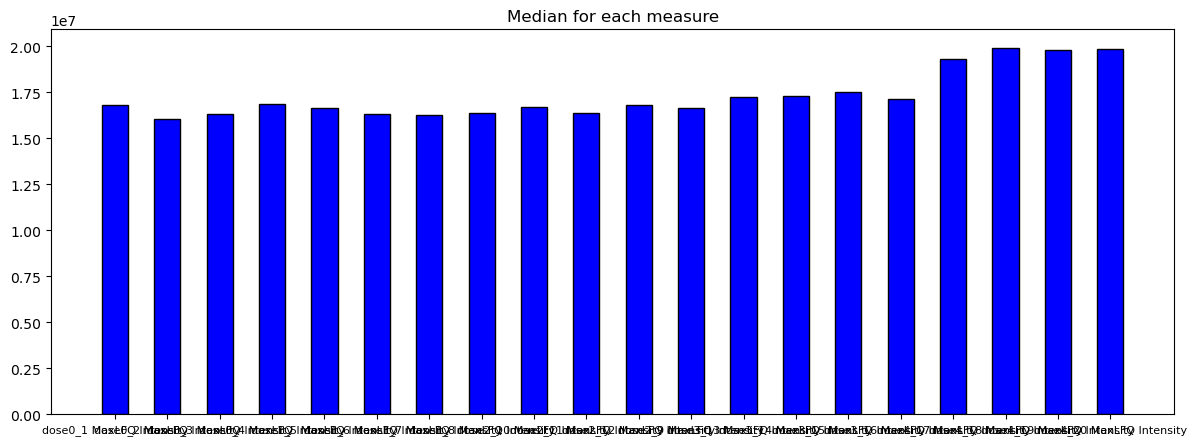

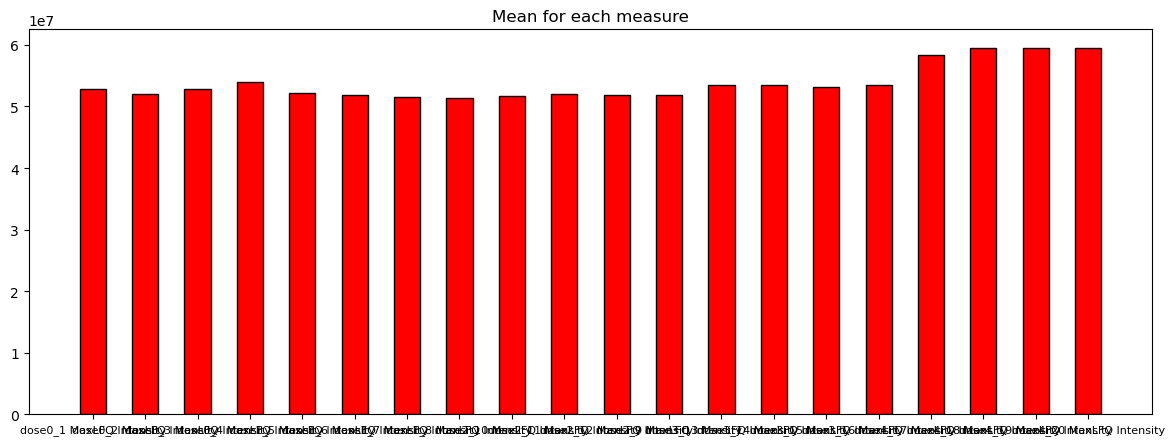

Do you want to delete a column (YES: 1 | NO: 0)? 0


No columns deleted


Do you want to transformed the data into log2(x) (YES: 1 | NO: 0)? 1


The data are transformed into log2(x)
pca_result
[[-35.58206901   3.66409806]
 [-32.2728661    0.78926699]
 [-23.95812717 -30.51373937]
 [-27.38006222 -48.26784686]
 [-13.21425522   7.81106715]
 [-15.50409135   9.19677918]
 [-12.51145837  15.37746023]
 [-13.48477003  17.26653254]
 [ -1.58973805  17.96067363]
 [ -1.81942151  11.4116471 ]
 [  0.97308002   4.40058645]
 [ -2.92404104  13.6801462 ]
 [  7.64886929   5.29894325]
 [  7.71682042   2.0965666 ]
 [ 10.10907975   4.37782042]
 [ 11.77928975   0.44219726]
 [ 34.06432782  -6.15920919]
 [ 37.03504716  -4.48510564]
 [ 34.56354542  -7.88676197]
 [ 36.35084045 -16.46112204]]


Do you want to export the PCA biplot into a png file (YES: 1 | NO: 0)? 0


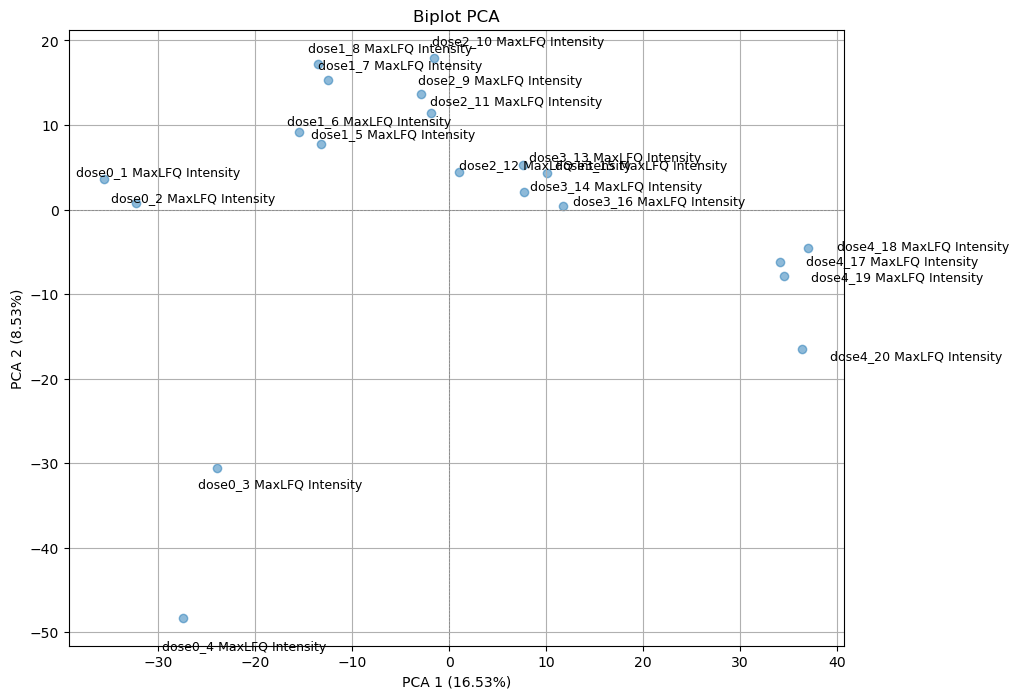

Do you want to delete a column (YES: 1 | NO: 0)? 0


No columns deleted


Do you want to perform another PCA ? (YES: 1 | NO: 0) 0


None: 0
Normalization on median by column: 1
Normalization by substrating control: 2
Normalization Z-score: 3


Which normalization do you want to perform ? 0


We will now compare the data groups with each other.

Please choose the protein reference
1. Protein
2. Protein ID
3. Entry Name
4. Gene
5. Organism
6. Protein Existence
7. Description


Enter the number associated with the reference you want (1, 2, etc.): 4


1. Homo sapiens
2. Escherichia coli (strain K12)


Please choose the tested category (1,2,.etc): 2
Please choose the control category (1,2,.etc): 1
Please choose the false discovery rate (0.01; 0.05; 0.1) 0.05
Do you know the diffrential ratio between the species ? (YES: 1 | NO: 0)? 1
Please select the differential ratio between the selected 2 groups (1.2, 1.5, 2..etc) 4
Please select the coefficient of variation (CV) you wanted (0.05, 0.1,0.2..etc) 0.2



Please choose the groups
1. 0
2. 1
3. 2
4. 3
5. 4


Please choose the first group (1,2,.etc): 5
Please choose the second group (1,2,.etc): 2


       ref_prot   p_value      category  difference  p_values_corrected  \
0     HNRNPA1L3  0.281605  Homo sapiens    0.094874            0.563590   
1          UBA6  0.305660  Homo sapiens    0.067856            0.579733   
2         ESYT2  0.083260  Homo sapiens   -0.200062            0.300061   
3         SHTN1  0.795074  Homo sapiens   -0.009837            0.917500   
4       TMEM223  0.861723  Homo sapiens    0.022755            0.948727   
...         ...       ...           ...         ...                 ...   
2961     NDUFB9  0.259564  Homo sapiens    0.070177            0.541017   
2962       SQOR  0.267011  Homo sapiens    0.076500            0.547687   
2963      WASF2  0.975985  Homo sapiens    0.026629            0.989427   
2964      MYO16  0.023674  Homo sapiens    1.733932            0.140999   
2965    SEC23IP  0.834692  Homo sapiens   -0.062482            0.940118   

      null hypothesis  
0               False  
1               False  
2               False  
3  

Do you want to export the volcanoplot into a png file (YES: 1 | NO: 0)? 1


The volcanoplot was exported succesfully


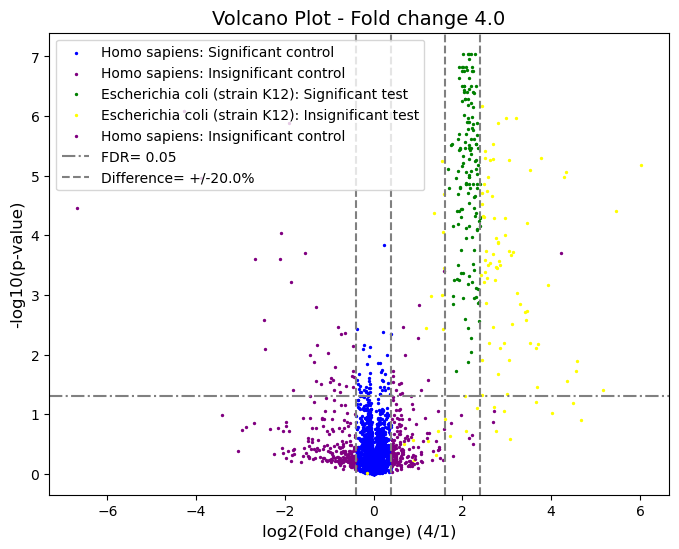

Do you want to export the results table into a txt file (YES: 1 | NO: 0)? 1


The results table was exported succesfully
Number of Escherichia coli (strain K12) proteins: 255
Number of Homo sapiens proteins: 2355
True Escherichia coli (strain K12): True positive= 152
True Homo sapiens: True negative= 2303
False Homo sapiens: False positive= 52
False Escherichia coli (strain K12): False negative= 103

Confusion matrix:                     Prediction : Positive  Prediction : Negative
Reality : Positive                    152                    103
Reality : Negative                     52                   2303


Accuracy= 0.941
Precision= 0.745
Sensitivity/Recall= 0.596
Specificity=0.978
F1-score=0.662


Do you want to compare others data groups ? (YES: 1 | NO: 0) 1
Do you want to change the configaration (FDR,CV..) ? (YES: 1 | NO: 0) 0


We will now compare the data groups with each other.

Please choose the groups
1. 0
2. 1
3. 2
4. 3
5. 4


Please choose the first group (1,2,.etc): 3
Please choose the second group (1,2,.etc): 2


       ref_prot   p_value      category  difference  p_values_corrected  \
0     HNRNPA1L3  0.391144  Homo sapiens   -0.080520            0.816020   
1          UBA6  0.485023  Homo sapiens    0.073302            0.851508   
2         ESYT2  0.683236  Homo sapiens   -0.031545            0.917986   
3         SHTN1  0.979530  Homo sapiens   -0.001472            0.993778   
4       TMEM223  0.968257  Homo sapiens    0.002874            0.990973   
...         ...       ...           ...         ...                 ...   
2961     NDUFB9  0.994343  Homo sapiens    0.000616            0.997706   
2962       SQOR  0.230772  Homo sapiens    0.078852            0.723985   
2963      WASF2  0.913185  Homo sapiens   -0.101113            0.980628   
2964      MYO16  0.829622  Homo sapiens    0.206655            0.959676   
2965    SEC23IP  0.931590  Homo sapiens    0.012289            0.983894   

      null hypothesis  
0               False  
1               False  
2               False  
3  

In [ ]:
while True:
    method=input("What is the data acqusition method ? (DDA: 1 | DIA: 2)")
    if method.isdigit():
        method=int(method)
        if method==1:
            ans_gene_name_add_DDA=int(input("Do you want to add a column for gene name of each protein ? (YES: 1 | NO: 0)"))
            if ans_gene_name_add_DDA==1:
                gene_name_add_DDA(df_data)
                break
            elif ans_gene_name_add_DDA==0:
                break
            else:
                print('Invalid input')
        elif method==2:
            ans_categories_add_DIA=int(input("Do you want to add a column for catagories (Organism) ? (YES: 1 | NO: 0)"))
            if ans_categories_add_DIA==1:
                categories_add_DIA(df_data)
                break
            elif ans_categories_add_DIA==0:
                break
            else:
                print('Invalid input')
    else:
        print('Invalid input')
n_proteins_start=len(df_data)
nb_PCA=0
while True:
    nb_samples=input("What is the number of samples?")
    if nb_samples.isdigit():
        nb_samples=int(nb_samples)
        break
    else:
        print('Invalid input')
while True:
    nb_repeats=input("What is the number of repeats by samples?")
    if nb_repeats.isdigit():
        nb_repeats=int(nb_repeats)
        break
    else:
        print('Invalid input')
nb_measure=nb_repeats*nb_samples

variables, main_column_deletion_flag=classifier_variables(df_data)
nb_column_to_delete=len(variables['MAIN'])-nb_measure
while True:
    ans_renaming=input("Do you want to rename the samples ? (YES: 1 | NO: 0)")
    if ans_renaming.isdigit():
        ans_renaming=int(ans_renaming)
        if ans_renaming==1:
            if main_column_deletion_flag==True:
                variables, df_data=rename_samples(df_data,df_info,variables)
                print('\n')
                print(f'You have to delete {nb_column_to_delete} "MAIN" column(s)')
                df_data, variables=column_deletion_2v(df_data, variables)
                break
            elif main_column_deletion_flag==False:
                variables, df_data=rename_samples(df_data,df_info,variables)
                break
        if ans_renaming==0:
            if main_column_deletion_flag==True:
                print('\n')
                print(f'You have to delete {nb_column_to_delete} "MAIN" column(s)')
                df_data, variables=column_deletion_2v(df_data,variables)
                #df_data,variables=prefix_deletion(df_data,variables)
                #df_data,variables=suffix_deletion(df_data,variables)
                break
            elif main_column_deletion_flag==False:
                df_data,variables=prefix_deletion(df_data,variables)
                break
    else:
        print('Invalid input')
df_data=fill_empty_cat(df_data,variables)
categories=classifier_categories(df_data,variables)
df_data, categories=categories_removal(df_data, categories, variables)
if method==1:
    if 'Contaminant' in df_data.columns:
        df_data=contaminant_removal(df_data)
#df_data=empty_row_removal(df_data, variables,n_proteins_start)
samples_groups=grouping(df_data,variables,nb_samples, nb_repeats)
df_data=filter_rows(df_data,samples_groups,nb_repeats,n_proteins_start,nb_repeats)
descriptive_stat(df_data, variables)
df_data, variables, samples_groups=column_deletion_3v(df_data, variables,samples_groups)
df_data=log2_transform(df_data,variables)
df_data=data_imputation(df_data,variables)
nb_PCA=PCA_data(df_data,variables,nb_PCA)
df_data, variables, samples_groups=column_deletion_3v(df_data, variables,samples_groups)
ans_analysis=int(input('Do you want to perform another PCA ? (YES: 1 | NO: 0)'))
if ans_analysis==1:
        PCA_data(df_data,variables,nb_PCA)
while True:
    df_data_draft=df_data
    print('None: 0\nNormalization on median by column: 1\nNormalization by substrating control: 2\nNormalization Z-score: 3')
    normalization=int(input('Which normalization do you want to perform ?'))
    normalization=0
    if normalization==0:
        break
    if normalization==1:
        df_data_draft=median_substraction_column(df_data_draft,variables)
        PCA_data(df_data_draft,variables)
        ans_normalization=int(input('Does the normalization is good? (YES: 1 | NO: 0)'))
        if ans_normalization==1:
            df_data=median_substration(df_data,variables,subgroups)
            break
        if ans_normalization==0:
            df_data_draft=df_data
        else:
            print('Invalid input')
    if normalization==2:
        print("This normalization isn't available yet")
    if normalization==3:
        df_data_draft=row_z_score_normalization(df_data_draft,variables)
        PCA_data(df_data_draft,variables)
        ans_normalization=int(input('Does the normalization is good? (YES: 1 | NO: 0)'))
        if ans_normalization==1:
            df_data=row_z_score_normalization(df_data,variables)
            break
        if ans_normalization==0:
            df_data_draft=df_data
        else:
            print('Invalid input')
    else:
        print('Invalid input')
flag_config=True
while True:
    print('We will now compare the data groups with each other.')
    if flag_config==True:
        FDR,cat_tested,cat_ctrl,RATIO,CV,flag_ratio,choice_ref=config(categories,variables)  
    df_results,first_group,second_group=paired_t_test(df_data,variables,categories,samples_groups,choice_ref)
    df_volcano=volcano_plot(df_results,first_group,second_group,categories,FDR,cat_tested,cat_ctrl,RATIO,CV,flag_ratio)
    parameters(df_volcano, categories,cat_tested,cat_ctrl)
    ans_data=int(input('Do you want to compare others data groups ? (YES: 1 | NO: 0)'))
    if ans_data==0:
            break
    if ans_data==1:
        ans_config=int(input('Do you want to change the configaration (FDR,CV..) ? (YES: 1 | NO: 0)'))
        if ans_config==0:
            flag_config=False
        if ans_config==1:
            flag_config=True
        
print('The analysis is done')

- prefixe
- human false
- volcano sans ligne, sans ratio=semiquant significatif ou non ? ce qui bouge ou non
- revoir pedagogie texte